# Application of FRANKEN-Z to Real Data

This notebook demonstrates an application of FRANKEN-Z to S16A **Hyper Suprime-Cam (HSC) Subaru Strategic Program (SSP) survey data**. As the training data includes $\sim\!400,000$ objects that have been **inhomogeneously sampled** (cobbled together from various surveys) with **varying errors** (stochastic backgrounds) and **depths** (collected from wide, deep, and ultra-deep fields) along with **multiple flux measurements** (PSF, Cmodel, and fiber/aperture quantities) and **randomly censored data** (from failed extractions and missing coverage), modeling these data provides many new challenges and opportunities.

This second notebook runs through cross-validation tests to see how well we do on the training sample for our fiducial model (from part 1), including tests on the reliability of the PDFs. We also demonstrate how hierarchical Bayes modeling can help us derive joint constraints on the $dN/dz$ and individual $P(z|\mathbf{F}_g)$'s, and briefly discuss the impact of selection effects.

# Setup

Let's initialize the environment.

In [1]:
import sys # system commands
from scipy import stats # statistics
from scipy import special # special functions
from astropy.io import fits # reading fits files

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Importing FRANKEN-Z config files...

In [2]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])
Nf=filt.NFILTER

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color

Importing HSC data...

In [3]:
# load observed data
data=fits.open('/Users/Josh/Dropbox/HSC/HSC_photoz/catalogs/hsc_s16a_combined_specz_highq_clean_errsim_train_v1.fits')[1].data
print 'Training objects:',len(data)

Training objects: 373432


In our first notebook, we settled on psf-matched aperture (i.e. "afterburner") photometry **alone** as our best-performing fiducial model. So we only need to extract that data along with cmodel photometry (which we use as a magnitude proxy).

In [4]:
aphot=10**(-0.4*c_[data['a_g'],data['a_r'],data['a_i'],data['a_z'],data['a_y']])
print 'Median correction:',median(aphot,axis=0)

Median correction: [ 0.94042301  0.95740581  0.96941328  0.97632635  0.97976404]


In [5]:
flux_cmodel=c_[data['gcmodel_flux'],data['rcmodel_flux'],data['icmodel_flux'],data['zcmodel_flux'],data['ycmodel_flux']]*aphot
err_cmodel=c_[data['gcmodel_flux_err'],data['rcmodel_flux_err'],data['icmodel_flux_err'],
           data['zcmodel_flux_err'],data['ycmodel_flux_err']]*aphot
err_cmodel_wide=c_[data['gcmodel_flux_err_wide'],data['rcmodel_flux_err_wide'],data['icmodel_flux_err_wide'],
                data['zcmodel_flux_err_wide'],data['ycmodel_flux_err_wide']]*aphot
mask_cmodel=(err_cmodel>0.)&isfinite(err_cmodel)
print 'Objects with missing values:',(mask_cmodel.sum(axis=1)<Nf).sum()

Objects with missing values: 0


In [6]:
flux_afterburner=c_[data['gparent_flux_convolved_2_1'],data['rparent_flux_convolved_2_1'],data['iparent_flux_convolved_2_1'],
                   data['zparent_flux_convolved_2_1'],data['yparent_flux_convolved_2_1']]*aphot
err_afterburner=c_[data['gflux_aperture15_err'],data['rflux_aperture15_err'],data['iflux_aperture15_err'],
                   data['zflux_aperture15_err'],data['yflux_aperture15_err']]*aphot

mask_afterburner=(err_afterburner>0.)&isfinite(err_afterburner)
print 'Objects with missing values:',(mask_afterburner.sum(axis=1)<Nf).sum()

Objects with missing values: 3


Extracting redshifts...

In [7]:
z,ze,zt,zs=data['redshift'],data['redshift_err'],data['redshift_type'],data['redshift_source']
ze[ze<0]=0.

Initializing general catalog features...

In [8]:
Nobs=len(data) # number of objects
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(err_cmodel,axis=0) # "background" skynoise (used for consistent mappings)
mag_cmodel,magerr_cmodel=fz.asinh_mag_map(flux_cmodel,err_cmodel_wide,skynoise,zeropoint=flux_zeropoint) # Luptitude mapping
mag_afterburner,magerr_afterburner=fz.asinh_mag_map(flux_afterburner,err_cmodel_wide,skynoise,zeropoint=flux_zeropoint)
depth=data['depth'] # depth of sample
cv=data['crossval_sample'] # cross-validation fold
cv_weights=data['crossval_weights'] # magnitude-color weights

Nfolds=max(cv)

In [9]:
lzidx,lzeidx=rdict.fit(log(1+z),ze/(1+z)) # discretize redshifts
magidx,mageidx=mdict.fit(mag_cmodel,magerr_cmodel) # discretize magnitudes

# Fiducial Model

Before we move onto testing, let's take some time to think about our fiducial model. In the first notebook, we found that no indivudal flux set(s) or combination of flux sets could outperform using **psf-matched aperture photometry**. Since the majority of our mag/color weights are located at fainter magnitudes ($i\sim24.5$), this means the majority of our quality metrics are dominated by COSMOS/3DHST photo-z's. These have been derived using template-fitting methods, which are color-based. This suggests that **psf-matched aperture photometry provides more accurate colors at fainter magnitudes** in our data (in addition to brighter magnitudes, where they are expected to perform better by design).

This is not necessarily true in terms of total flux, however, which is shown below.

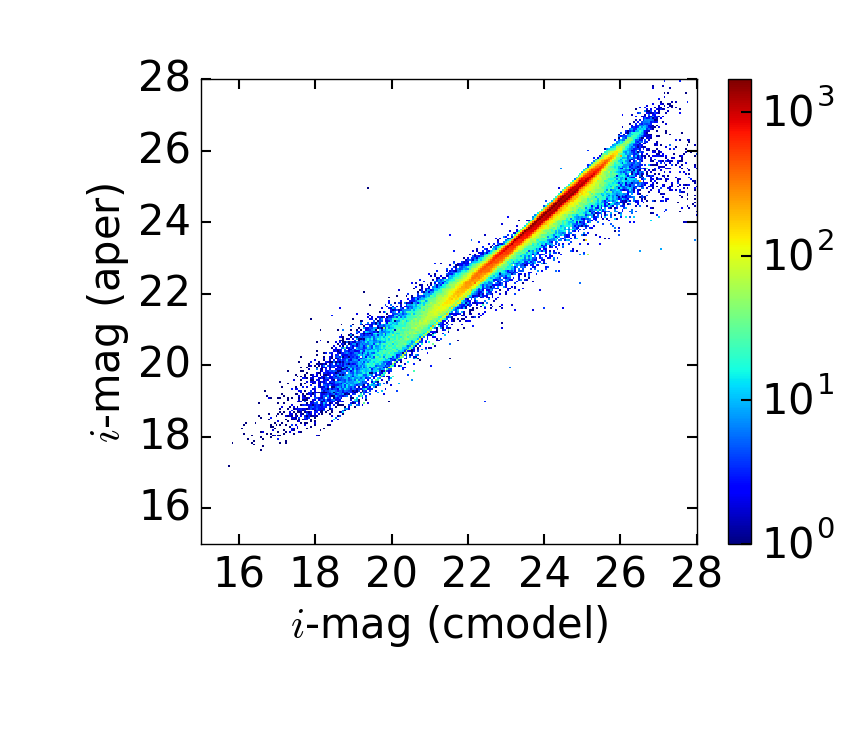

In [10]:
figure(figsize=(8,6))
h=hist2d(mag_cmodel[:,2],mag_afterburner[:,2],bins=[arange(10,30,0.05),arange(10,30,0.05)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([15,28])
xlabel('$i$-mag (cmodel)')
ylim([15,28])
ylabel('$i$-mag (aper)')

Our neighborhood search doesn't necessarily care about having good absolute magnitudes, however, as long as there is (1) a well-defined relation between the true magnitude and the measured one (i.e. a strong correlation, which exists) and (2) relative differences in observed  magnitudes correspond in a direct way to the true magnitudes (i.e. low scatter, which also exists).

This is also supported by the fact that adding the additional measurements did not add more information, which implies that the *relative* quantities measured by the psf-matched aperture fluxes contained most of the information present in more accurate (but possibly more noisy) total flux measurements.

## Generate Cross-Validation Predictions

In [11]:
N_members=25 # number of trees/Monte Carlo realizations used for FRANKEN-Z nearest-neighbor search
N_neighbors=10 # number of neighbors selected at each iteration

model_obj=empty((Nobs,N_members*N_neighbors)).astype(int)
model_Nobj=empty(Nobs).astype(int)
model_ll=empty((Nobs,N_members*N_neighbors))
model_Nbands=empty((Nobs,N_members*N_neighbors)).astype(int)

for i in xrange(Nfolds):
    sys.stdout.write(str(i+1)+': ')
    test_sel=cv==(i+1)
    train_sel=(test_sel==False)
    tsel=arange(Nobs)[train_sel]
    
    p1,v1,m1=flux_afterburner[train_sel],square(err_afterburner[train_sel]),mask_afterburner[train_sel]
    p2,v2,m2=flux_afterburner[test_sel],square(err_cmodel_wide[test_sel]),mask_afterburner[test_sel]
    e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

    mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
    mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

    # initialize WINBET instances
    winbet_train=fz.WINBET(Ntrees=N_members,Nleaf=N_neighbors) # initialize WINBET (training sample)
    winbet_test=fz.WINBET(Ntrees=N_members,Nleaf=N_neighbors) # intialize WINBET (testing sample)
    if (m1==False).sum()>0:
        winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
    else:
        winbet_train=None
    if (m2==False).sum()>0:
        winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
    else:
        winbet_test=None

    frankenz=fz.FRANKENZ(N_members=N_members,n_neighbors=N_neighbors)
    temp=frankenz.predict(p1,e1,m1,p2,e2,m2,impute_train=winbet_train,impute_test=winbet_test)
    model_obj[test_sel],model_Nobj[test_sel],model_ll[test_sel],model_Nbands[test_sel]=temp
    model_obj[test_sel]=tsel[model_obj[test_sel]] # re-indexing to match full training data (not subsample)

1: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 0 9 0 10 0 11 0 12 0 13 0 14 0 15 0 16 0 17 0 18 0 19 0 20 0 21 0 22 0 23 0 24 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
2: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 0 9 0 10 0 11 0 12 0 13 0 14 0 15 0 16 0 17 0 18 0 19 0 20 0 21 0 22 0 23 0 24 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
3: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
4: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 2

In [ ]:
# correcting for re-indexing transformation, which converts -99's into arbitrary values
for i in xrange(Nobs):
    model_obj[i][model_Nobj[i]:]=-99

Let's now save these arrays to disk. 

In [62]:
cols=fits.ColDefs([
        fits.Column(name='model_obj',format='250J',array=model_obj),
        fits.Column(name='model_Nobj',format='J',array=model_Nobj),
        fits.Column(name='model_ll',format='250D',array=model_ll),
        fits.Column(name='model_Nbands',format='250I',array=model_Nbands),
        ])
tbhdu=fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv.fits',clobber=True)

These are the "raw" output files from FRANKEN-Z that encode the most relevant information: the (sparse) mapping from the testing set onto the training set.

## Cross-Validation Redshift Tests

In [10]:
N_members=25 # number of trees/Monte Carlo realizations used for FRANKEN-Z nearest-neighbor search
N_neighbors=10 # number of neighbors selected at each iteration

results=fits.open('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv.fits')[1].data
model_obj=results['model_obj']
model_Nobj=results['model_Nobj']
model_ll=results['model_ll']
model_Nbands=results['model_Nbands']

del results

Let's now take a look at our redshift performance.

In [11]:
# generate redshifts
model_llmin=empty(Nobs).astype(float)
lzpdf=empty((Nobs,rdict.Nz))
zpdf=empty((Nobs,rdict.Nz_out))
model_levidence=empty(Nobs)

for i in xrange(Nobs):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx[midx],lzeidx[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360

As before, we'll first examine the median point estimate predictions to see how we're doing.

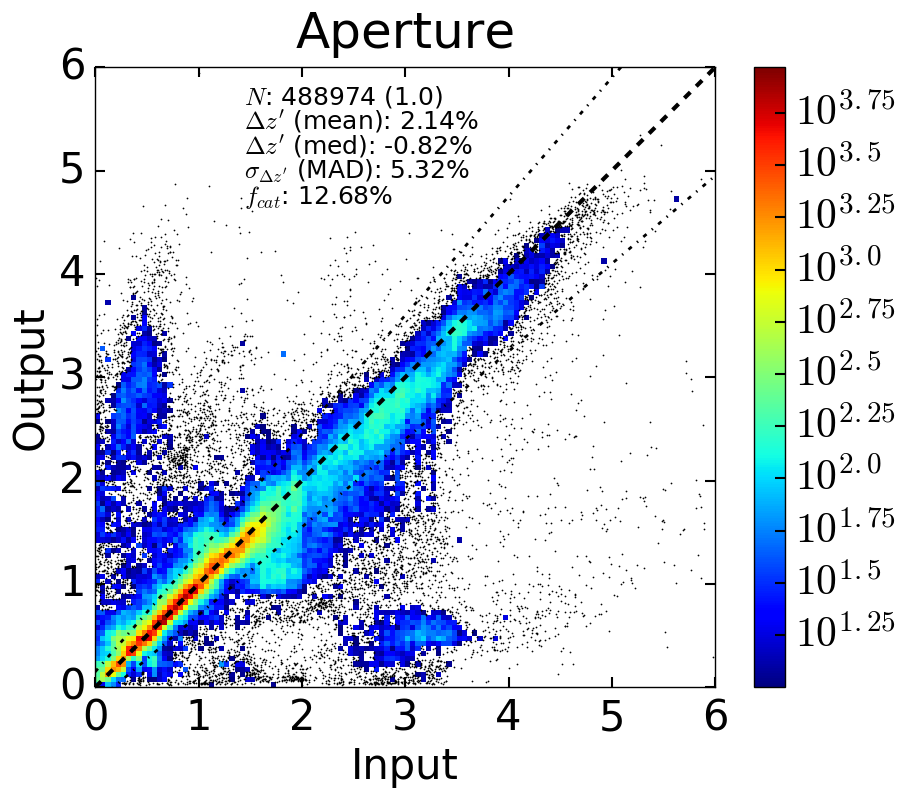

In [19]:
# plotting results
figure(figsize=(10,8))
pz_metrics=fz.plot_zpoints('Aperture',z,zpoints[1],weights=cv_weights)

As a quick quality check on our PDFs, we can implement a cut on $\sigma_z/(1+z_{50})<0.15$ to see how much "cleaner" our results get.

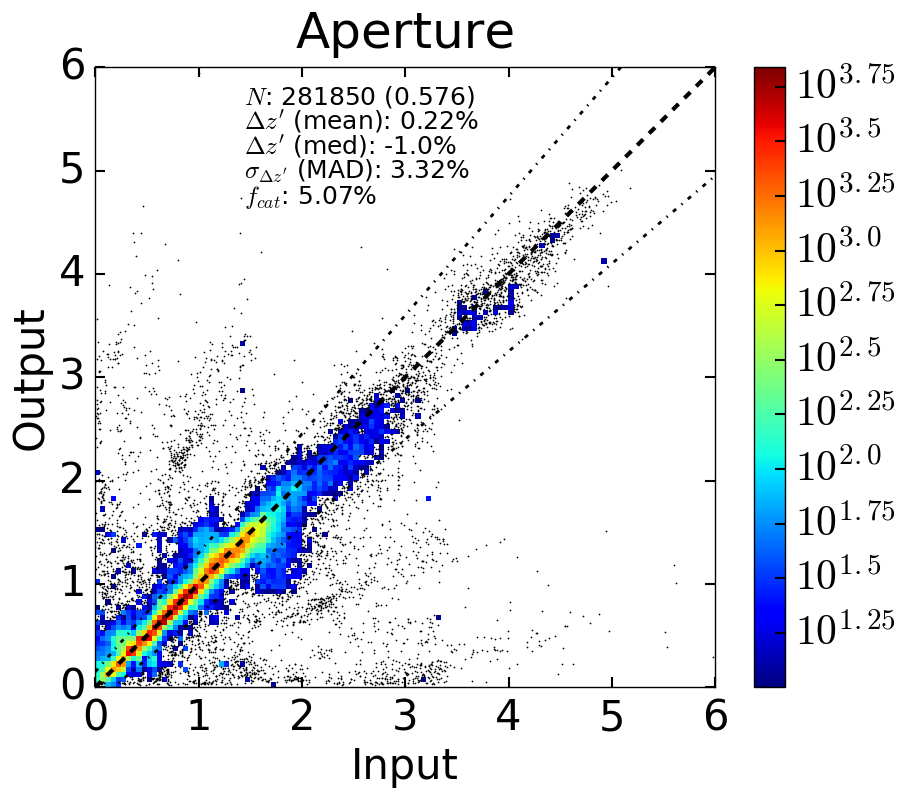

In [20]:
# plotting results
figure(figsize=(10,8))
pz_metrics=fz.plot_zpoints('Aperture',z,zpoints[1],weights=cv_weights,selection=zpoints[-2]/(1+zpoints[1])<0.15)

The significant reduction in scatter and outliers suggests our PDFs also look quite reasonable. Now let's move on to the population distribution.

C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


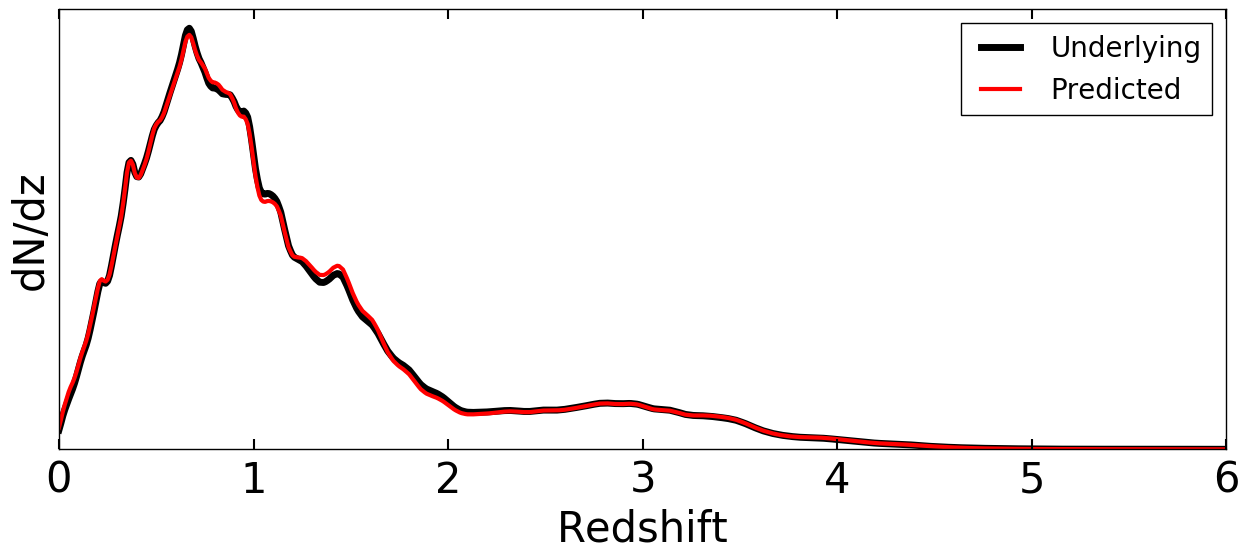

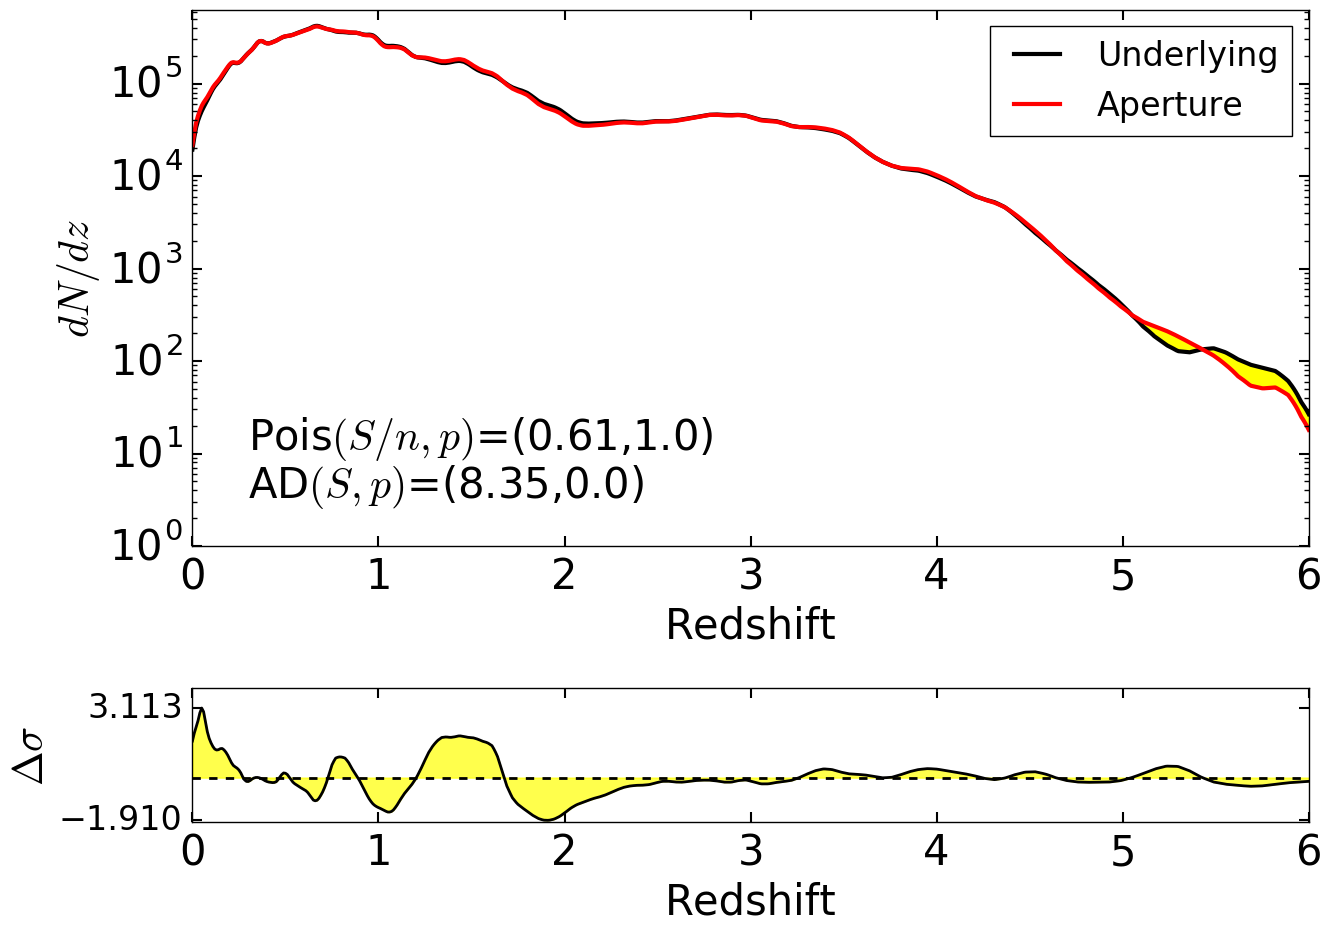

In [21]:
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[:,None],axis=0)/cv_weights.sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights.sum(),nz_stack*cv_weights.sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aperture'],colors=['black','red'])

Our reconstruction of the underlying $dN/dz$ looks quite good, so let's now move onto inspecting the stacked PDFs themselves.

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 Computing PDF quantities...0 done!
Resampling PDFs...0 done!


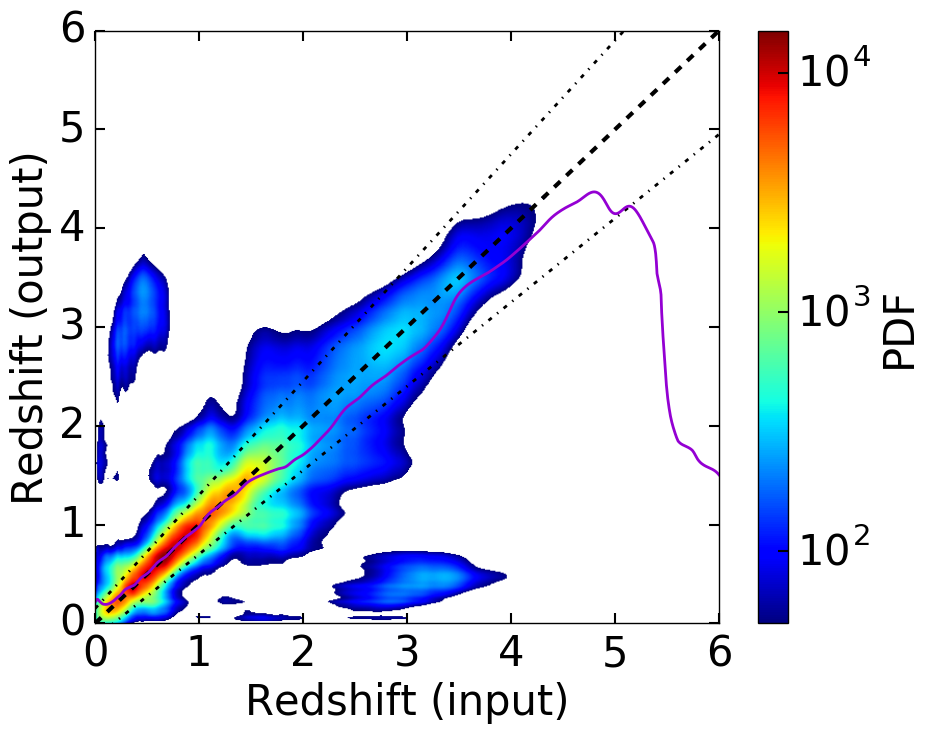

In [22]:
figure(figsize=(10,8))
z2dstack,z2dprob,z2dpoints=fz.plot_zpdfstack(zpdf,rdict.zgrid_out,lzidx,lzeidx,rdict,weights=cv_weights)

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 Computing PDF quantities...0 done!


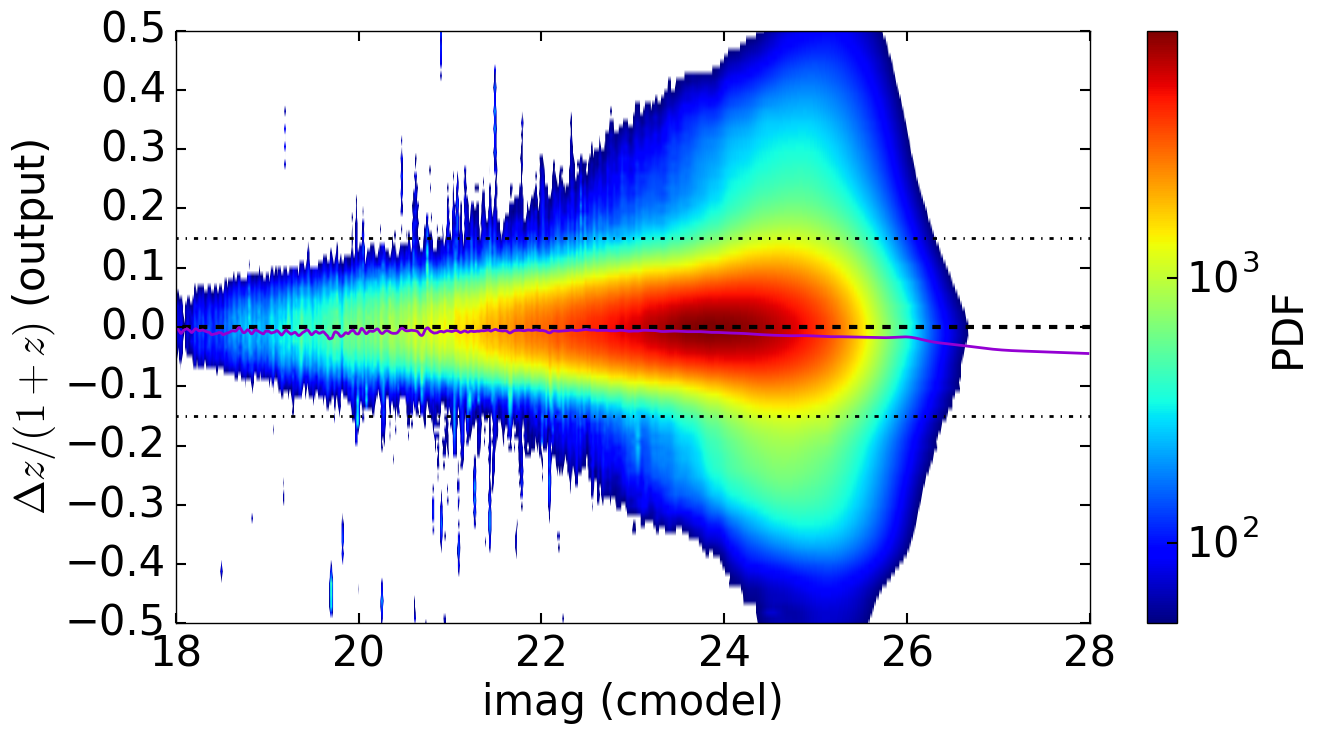

In [23]:
figure(figsize=(14,8))
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,z,magidx[:,2],mageidx[:,2],mdict,
                                          [18,28,2.],'imag (cmodel)',weights=cv_weights,boxcar=10)

Since we're using a heterogeneous sample, it's also useful to check how well we're performing on each given redshift type.

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 Computing PDF quantities...0 done!
0 5000 10000 15000 20000 25000 30000 35000 Computing PDF quantities...0 done!
0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 Computing PDF quantities...0 done!


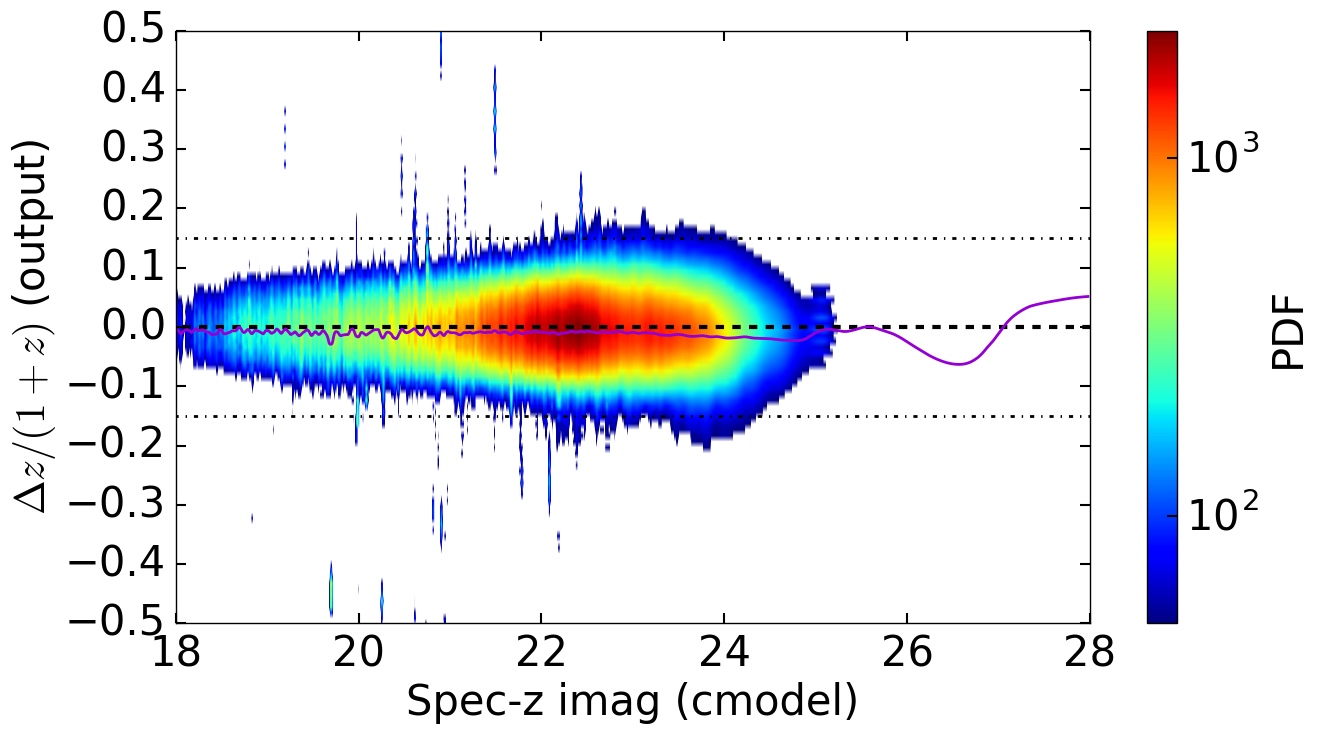

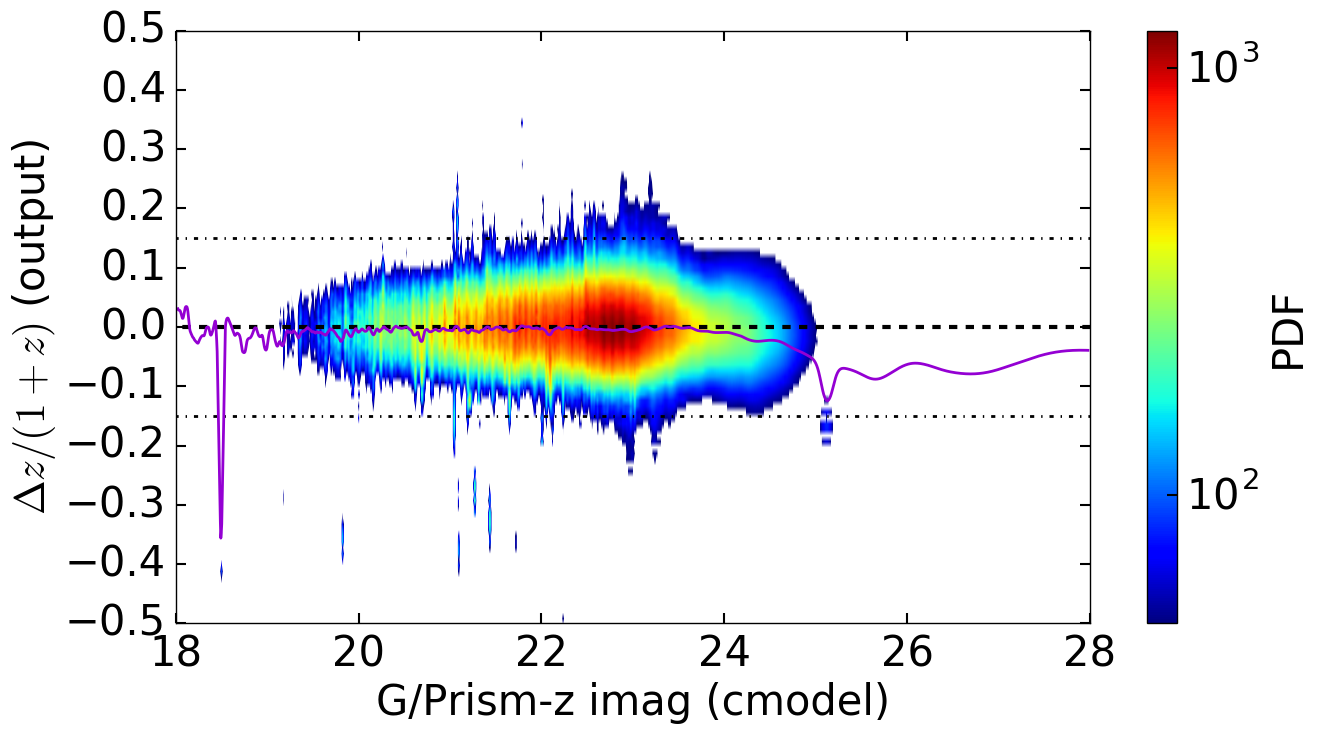

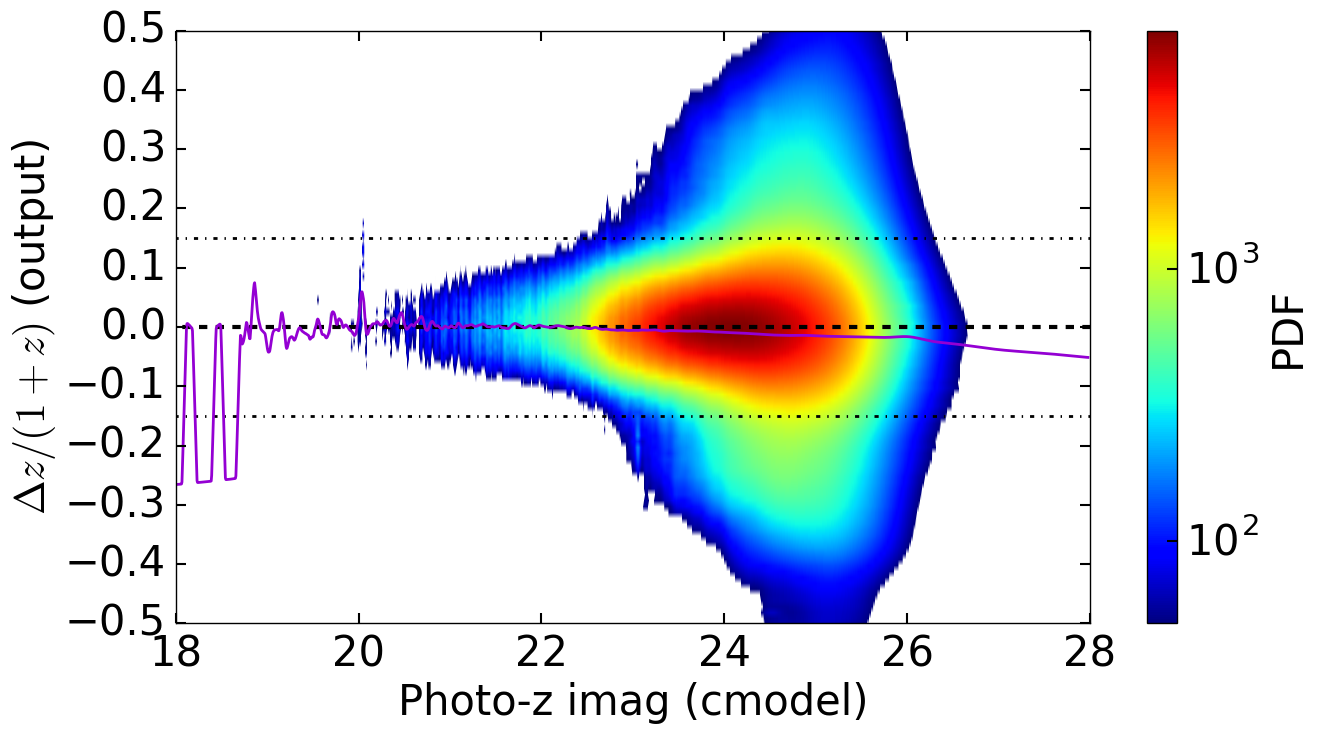

In [26]:
figure(figsize=(14,8))
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,z,magidx[:,2],mageidx[:,2],mdict,
                                          [18,28,2.],'Spec-z imag (cmodel)',sel=(zt==1),weights=cv_weights,boxcar=10)

figure(figsize=(14,8))
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,z,magidx[:,2],mageidx[:,2],mdict,
                                          [18,28,2.],'G/Prism-z imag (cmodel)',sel=(zt==2),weights=cv_weights,boxcar=10)

figure(figsize=(14,8))
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,z,magidx[:,2],mageidx[:,2],mdict,
                                          [18,28,2.],'Photo-z imag (cmodel)',sel=(zt==3),weights=cv_weights,boxcar=10)

Combined, these confirm that our stacked PDFs also show very good behavior and performance across the sample.

Let's now check how our fits break down by redshift type. We can do this in a rough sense by computing $f_t$ (the fraction of neighbors of type $t$) and $p_t$ (the portion of the posterior from type $t$).

In [12]:
# compute Ntype and Ptype
model_Ntype=zeros((Nobs,3))
model_Ptype=zeros((Nobs,3))

for i in xrange(Nobs):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    ztypes=zt[midx]-1
    like=exp(-0.5*(ll-model_llmin[i]))
    like/=like.sum()
    for j in xrange(Nm):
        model_Ntype[i][ztypes[j]]+=1
        model_Ptype[i][ztypes[j]]+=like[j]

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 

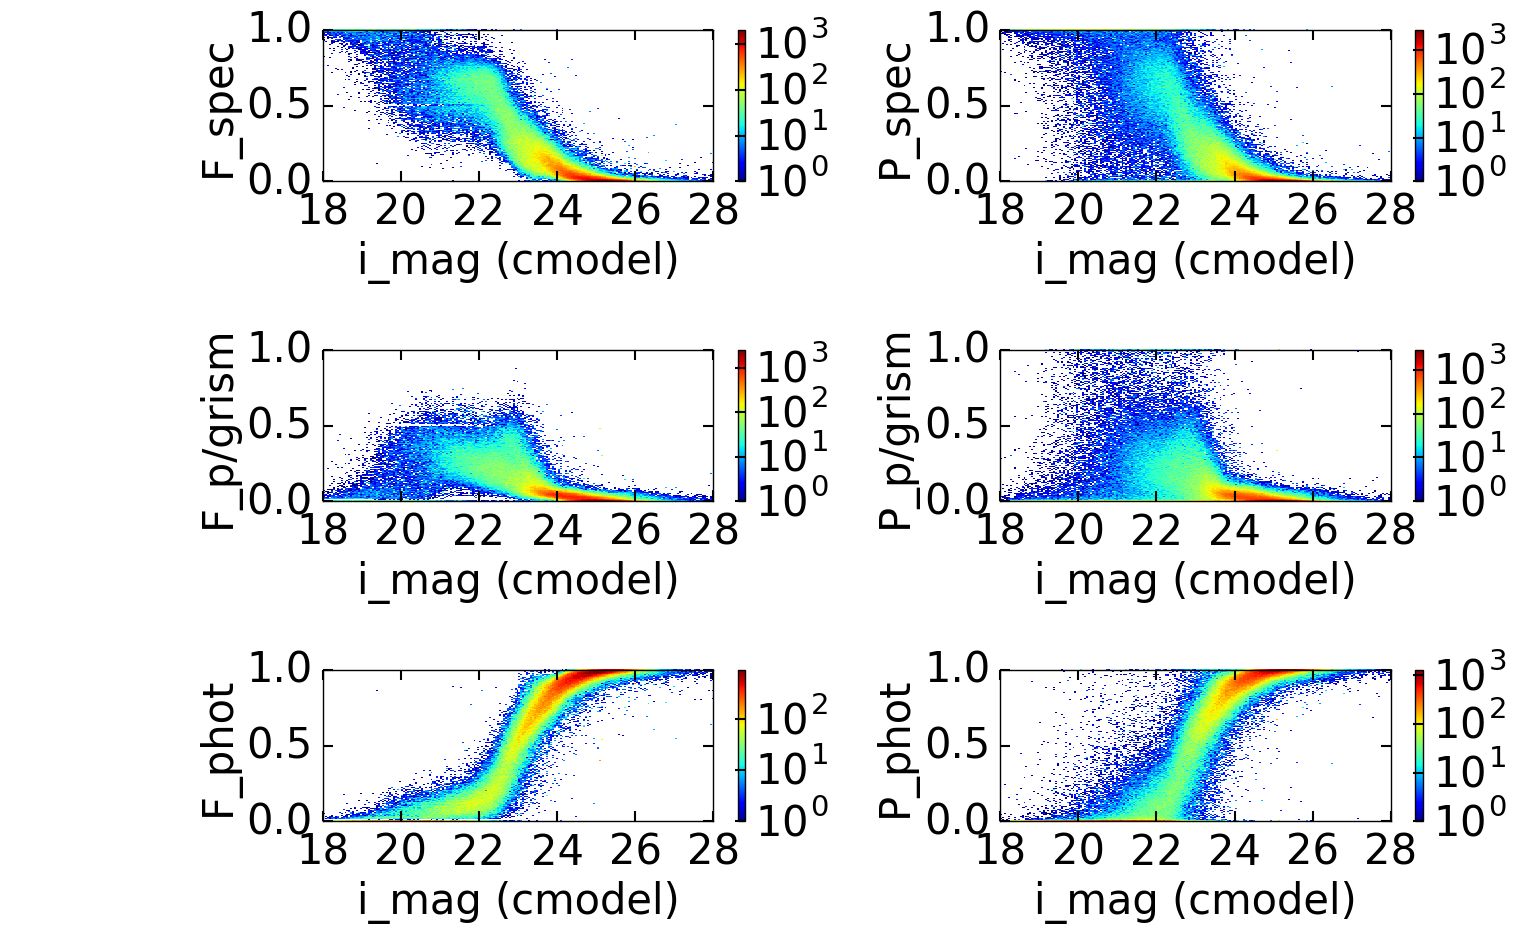

In [19]:
figure(figsize=(14,10))
subplot(3,2,1)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,0]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_spec')
tight_layout()
subplot(3,2,2)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,0],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_spec')
tight_layout()
subplot(3,2,3)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,1]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_p/grism')
tight_layout()
subplot(3,2,4)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,1],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_p/grism')
tight_layout()
subplot(3,2,5)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,2]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_phot')
tight_layout()
subplot(3,2,6)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,2],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_phot')
tight_layout()

As we expect, photo-z's tend to dominate the neighbors and likelihood fraction at faint magnitudes, with a sharp transition between 22nd and 24th mag.

## Incorporating Selection Effects

The HSC survey pipeline extracts photometry for objects if they are **detected at 5-$\sigma$ in *any* band**. We can write this detection selection effect $\gamma_{\textrm{det}}$ as the complement of *not* detecting an object at 5-$\sigma$ in *all* bands, which gives

\begin{equation}
P(\gamma_{\textrm{det}}|g) = 1-\prod_i \Phi(5\hat{\sigma}_{g,i}|\hat{F}_g,\hat{\sigma}_{g,i}) = 1-\prod_i \frac{1}{2}\textrm{erfc}\left[ \left(\hat{F}_{g,i}-5\hat{\sigma}_{g,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right]
\end{equation}

where the product over $i$ is taken over all relevant bands.

Additional selection effects such as color cuts or magnitude cuts are independent of these and so the probability of selecting a given galaxy $P(\gamma|g)$ can simply be written as the product of each independent selection effect:

\begin{equation}
P(\gamma|g)=\prod_i P(\gamma_i|g),
\end{equation}

where $i$ encompasses all relevant independent selection effects. 

For a flux cut over a flux boundary $\mathbf{F}_{\textrm{cut}}$, this can be written as (see *frankenz_tests.ipynb*)

\begin{equation}
P(\gamma_{\textrm{flux}}|g)= \prod_i \left( 1-\frac{1}{2}\textrm{erfc}\left[ \left(\hat{F}_{g,i}-F_{cut,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right] \right).
\end{equation}

For a color cut (i.e. flux ratio) over a flux ratio boundary $\mathbf{R}_{\textrm{cut}}$, we unfortunately are forced to deal with the [Gaussian ratio distribution](https://en.wikipedia.org/wiki/Ratio_distribution#Gaussian_ratio_distribution) $P_{\mathbf{R}}(\mathbf{r}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g)$. This does have an analytic (but not simple) form for the PDF, which enables us to compute the CDF $F_{\mathbf{R}}(\mathbf{r}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g)$, which we can use to derive $P(\gamma_{\textrm{color}}|g)$ following the procedure outlined in *frankenz_tests.ipynb*.

$P(\gamma|h)$ can be written as

\begin{equation}
P(\gamma|h) = \int P(g|h)P(\gamma|g) dg 
\end{equation}

This (almost certainly) cannot be evaluated analytically, but can be approximated numerically using a series of Monte Carlo fluxes drawn from the observed flux distribution $\lbrace\mathbf{\hat{F}}_g^1,\mathbf{\hat{F}}_g^2,\dots,\mathbf{\hat{F}}_g^n\rbrace \sim \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{\hat{F}}_{h},\mathbf{\hat{C}}_{h}+\mathbf{\hat{C}}_{g})$ via

\begin{equation}
P(\gamma|h) \approx \frac{1}{N} \sum_{t=1}^{N} P(\gamma|\mathbf{\hat{F}}_g^t,\mathbf{\hat{C}}_g).
\end{equation}

Although we won't be using any of these corrections here since we'll be running FRANKEN-Z over the entire catalog, this will be relevant when computing/modifying photo-z's to specific data subsets (such as weak lensing-selected data). We provide a simple illustration of this concept below for cmodel photometry.

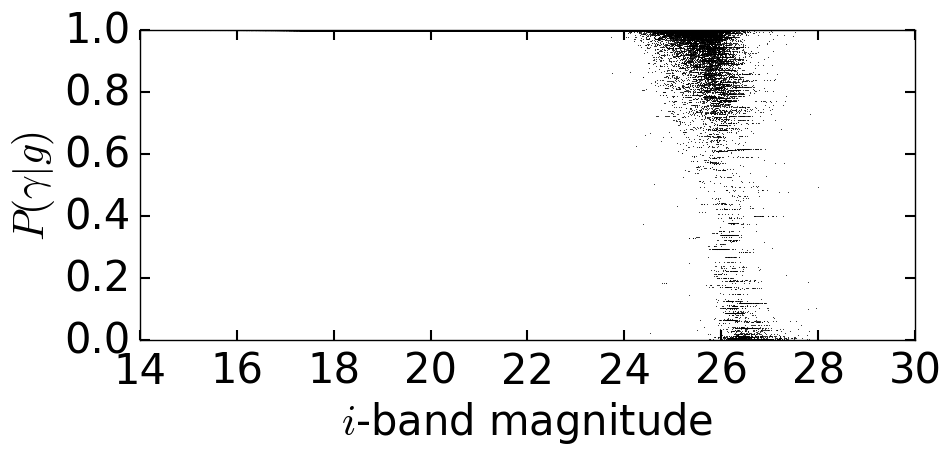

In [45]:
phot_sel=1-prod(0.5*special.erfc((flux_cmodel-5*err_cmodel_wide)/(sqrt(2)*err_cmodel_wide)),axis=1)

figure(figsize=(10,4))
plot(mag_cmodel[:,2],phot_sel,'.',color='black',markersize=0.5)
xlabel('$i$-band magnitude')
ylabel('$P(\gamma|g)$')

## Hierchical Modification

Now let's check how well we can derive errors on our $dN/dz$ distribution using our previous hierarchical models. Let's set our population prior $P(\mathbf{f^h})$ and initialize our population parameter vector $\mathbf{f}^{\mathbf{h}}_0$.

In [13]:
p_fh=ones(Nobs)/Nobs # uniform prior

In [65]:
fh=zeros(Nobs)
model_llmin=empty(Nobs) # min(log-likelihood)

for i in xrange(Nobs):
    Nm=model_Nobj[i] # number of models
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm] # model indices and corresponding log-likelihoods
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # weights
    weights[isfinite(weights)==False]=0 # assign failed computations (nan,inf) 0 weight
    weights*=p_fh[midx] # multiply by global prior
    weights/=weights.sum() # normalize
    fh[midx]+=weights # stack

Now that everything's all set up, we generate a bunch of $\mathbf{f^h}$ samples.

In [66]:
N_samples=100
fh_t=zeros((N_samples,len(fh)))

# Gibbs sampler
fh_t[0]=fh # initialize

for i in xrange(N_samples-1):
    sys.stdout.write(str(i)+' ')
    fh_i=random.dirichlet(fh_t[i]+1) # draw population
    for j in xrange(Nobs):
        Nm=model_Nobj[j] # number of models
        midx,ll,llmin=model_obj[j][:Nm],model_ll[j][:Nm],model_llmin[j]
        weights=exp(-0.5*(ll-llmin))
        weights[isfinite(weights)==False]=0 # assign failed computations (nan,inf) 0 weight
        weights*=fh_i[midx]*p_fh[midx] # (P(pop_global)*P(pop_conditional)*likelihood)
        fh_t[i+1][midx]+=weights/weights.sum()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

As with standard Metropolis-Hastings Markov Chain Monte Carlo (MCMC) sampling, we first have to guarantee our sampler converges before we begin drawing values to derive a joint PDF.

([], <a list of 0 Text yticklabel objects>)

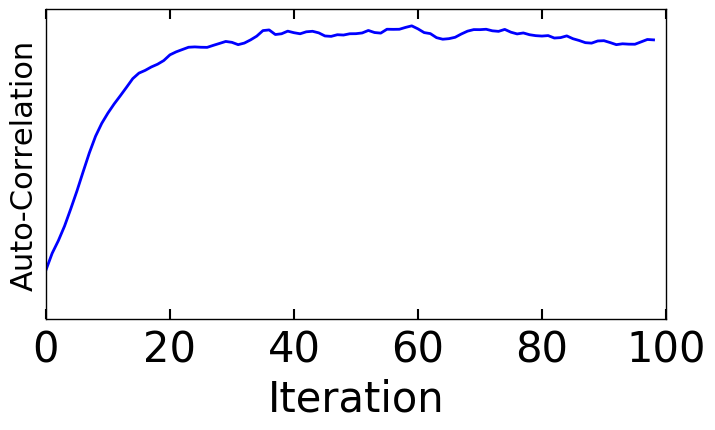

In [67]:
figure(figsize=(8,4))
plot([correlate(fh_t[i+1],fh_t[i]) for i in xrange(N_samples-1)],color='blue',lw=2)
xlabel('Iteration')
ylabel('Auto-Correlation',fontsize=22)
yticks([])

Starting at 40 appears reasonable.

**Important sidenote**: To properly condition a covariance/precision matrix, we need as many samples as "free parameters". This means we're limited by the resolution of our grid, and that saving on computation time using fewer samples will require downsampling our redshift, mass, etc. grid to coarser resolution using, e.g., binning.

In [68]:
N_burnin=40 # burn-in trials
z_pdf_draws=empty((N_samples-N_burnin,rdict.Nz_out)) # dn/dz draws

for i in xrange(N_burnin,N_samples):
    sys.stdout.write(str(i)+': ')
    midx=choice(Nobs,p=fh_t[i]/fh_t[i].sum(),size=Nobs) # sample from f^h
    temp1,temp2,temp3=lzidx[midx],lzeidx[midx],cv_weights[midx]
    pz=zeros(rdict.lzgrid_highres.shape)
    for j in xrange(Nobs):
        if j%20000==0: sys.stdout.write(str(j/20000)+' ')
        t1,t2,t3=temp1[j],temp2[j],temp3[j]
        w,k=rdict.sig_width[t2],rdict.sig_dict[t2]
        pz[choice(xrange(t1-w,t1+w+1),p=k/k.sum())]+=t3
    pz=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    pz=interp(rdict.zgrid_out,rdict.zgrid,pz)
    pz/=pz.sum()
    z_pdf_draws[i-N_burnin]=pz
z_pdf_draws_mean=z_pdf_draws.mean(axis=0)
z_pdf_draws_mean/=z_pdf_draws_mean.sum()
z_pdf_draws_std=z_pdf_draws.std(axis=0)

40: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 41: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 42: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 43: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 44: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 45: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 46: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 47: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 48: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 49: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 50: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 51: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 52: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 53: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 54: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 55: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 56: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 57: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 58: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 59: 0 1 2 3 4 5 6 7 8 9 10 11 1

Let's finally compare the difference between the original $dN/dz$ and the hierarchical Gibbs draws.

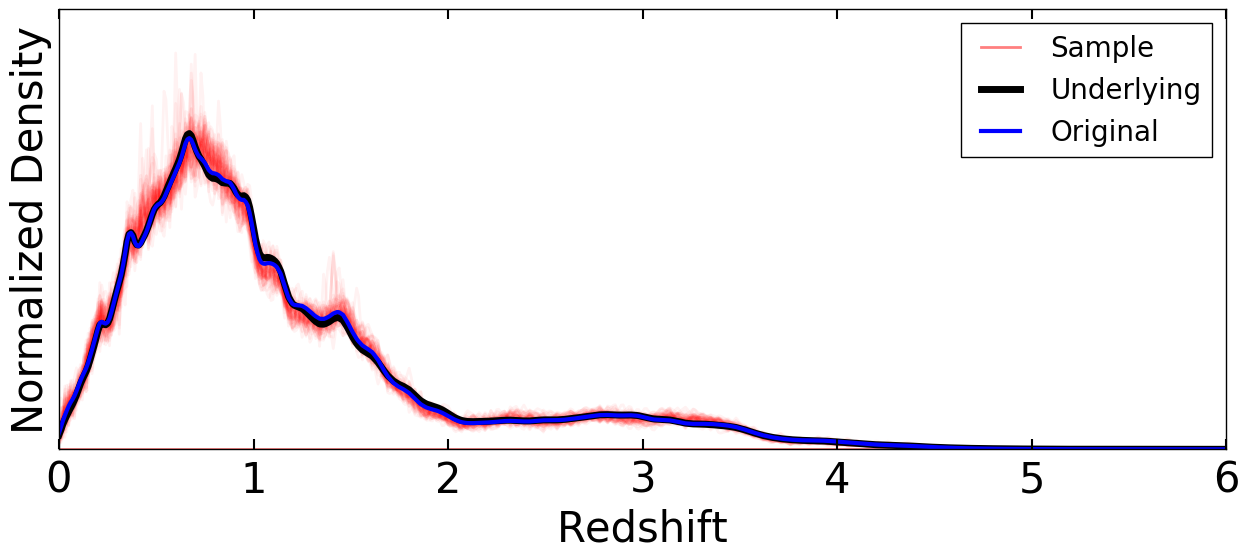

In [69]:
figure(figsize=(14,6))

plot(rdict.zgrid_out,zeros(rdict.Nz_out),lw=2,color='red',alpha=0.5,label='Sample')
[plot(rdict.zgrid_out,z_pdf_draws[i],lw=2,color='red',alpha=0.05) for i in xrange(N_samples-N_burnin)]

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

plot(rdict.zgrid_out,nz_stack,lw=3,color='blue',label='Original')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
tight_layout()
legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('Normalized Density')

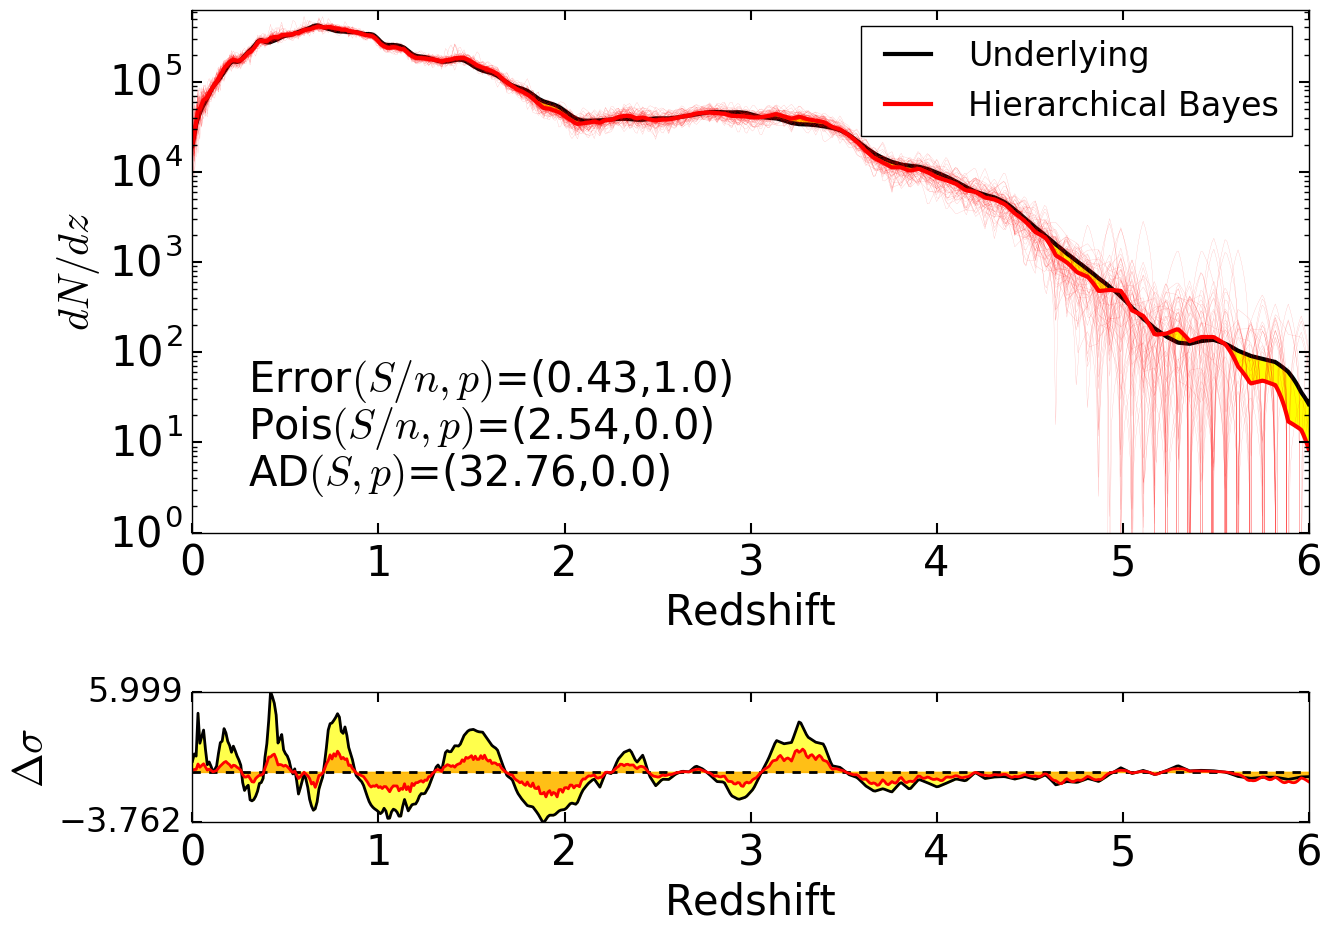

In [70]:
figure(figsize=(14,10))
Q_pois,Q_ad,Q_err=fz.plot_nz(z_pdf*int(cv_weights.sum()),z_pdf_draws_mean*int(cv_weights.sum()),
                             rdict.zgrid_out,rdict.dz_out,
                             out_nz_draws=z_pdf_draws*int(cv_weights.sum()),
                             sample_names=['Underlying','Hierarchical Bayes'],colors=['black','red'])

Some of the "beating" structure visible is due to aliasing between our $z$ vs $\ln(1+z)$ grid. That aside, however, we notice that our confidence intervals are excellent, and the underlying distribution entirely consistent with our draws. 

## Hierarchical Sampling, Continued

Let's now return to an issue from the first part of our notebook -- structure in the $dN/dz$ distribution. We noted that this structure mostly comes from the "high-quality" photo-z's we use for training, and thus represent inherent structure in the COSMOS 30-band photo-z solutions. This is shown below with respect to our hierarchical $dN/dz$ distribution.

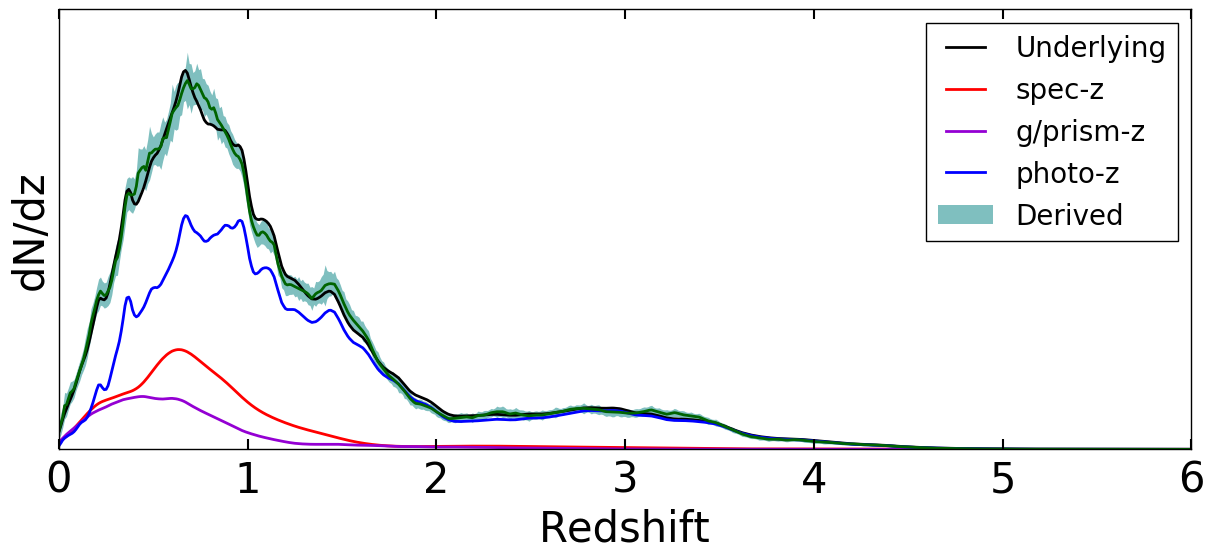

In [71]:
figure(figsize=(14,6))

plot(rdict.zgrid_out,z_pdf,lw=2,color='black',label='Underlying')

ztypes=['spec-z','g/prism-z','photo-z']
zcolors=['red','darkviolet','blue']
for i in xrange(3):
    w=cv_weights*(zt==(i+1))
    z_pdf_t=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,w,rdict.grid,rdict.delta,rdict.Ngrid)
    z_pdf_t=z_pdf_t[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    z_pdf_t=interp(rdict.zgrid_out,rdict.zgrid,z_pdf_t)
    z_pdf_t/=z_pdf_t.sum()
    plot(rdict.zgrid_out,z_pdf_t*w.sum()/cv_weights.sum(),lw=2,color=zcolors[i],label=ztypes[i])

plot(rdict.zgrid_out,z_pdf_draws_mean,lw=2,color='darkgreen')
fill_between(rdict.zgrid_out,z_pdf_draws_mean+z_pdf_draws_std,z_pdf_draws_mean-z_pdf_draws_std,
             color='teal',alpha=0.5,lw=0,label='Derived')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylim([0,None])
yticks([])
ylabel('dN/dz')

One way we can attempt to correct for this effect is to boost the contribution from spec-z's and g/prism-z's using a global prior based on redshift type. We can visualize this using our previous $f_t$ and $p_t$ plots.

In [72]:
p_fh=ones(Nobs)/Nobs # uniform prior
p_fh[zt==1]*=10 # upweight spec-z's by a factor of 10
p_fh[zt==2]*=5 # upweight grism-z's by a factor of 5
p_fh/=p_fh.sum()

# compute Ntype and Ptype
model_Ntype=zeros((Nobs,3))
model_Ptype=zeros((Nobs,3))

for i in xrange(Nobs):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    ztypes=zt[midx]-1
    like=exp(-0.5*(ll-model_llmin[i]))*p_fh[midx]
    like/=like.sum()
    for j in xrange(Nm):
        model_Ntype[i][ztypes[j]]+=1
        model_Ptype[i][ztypes[j]]+=like[j]

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 

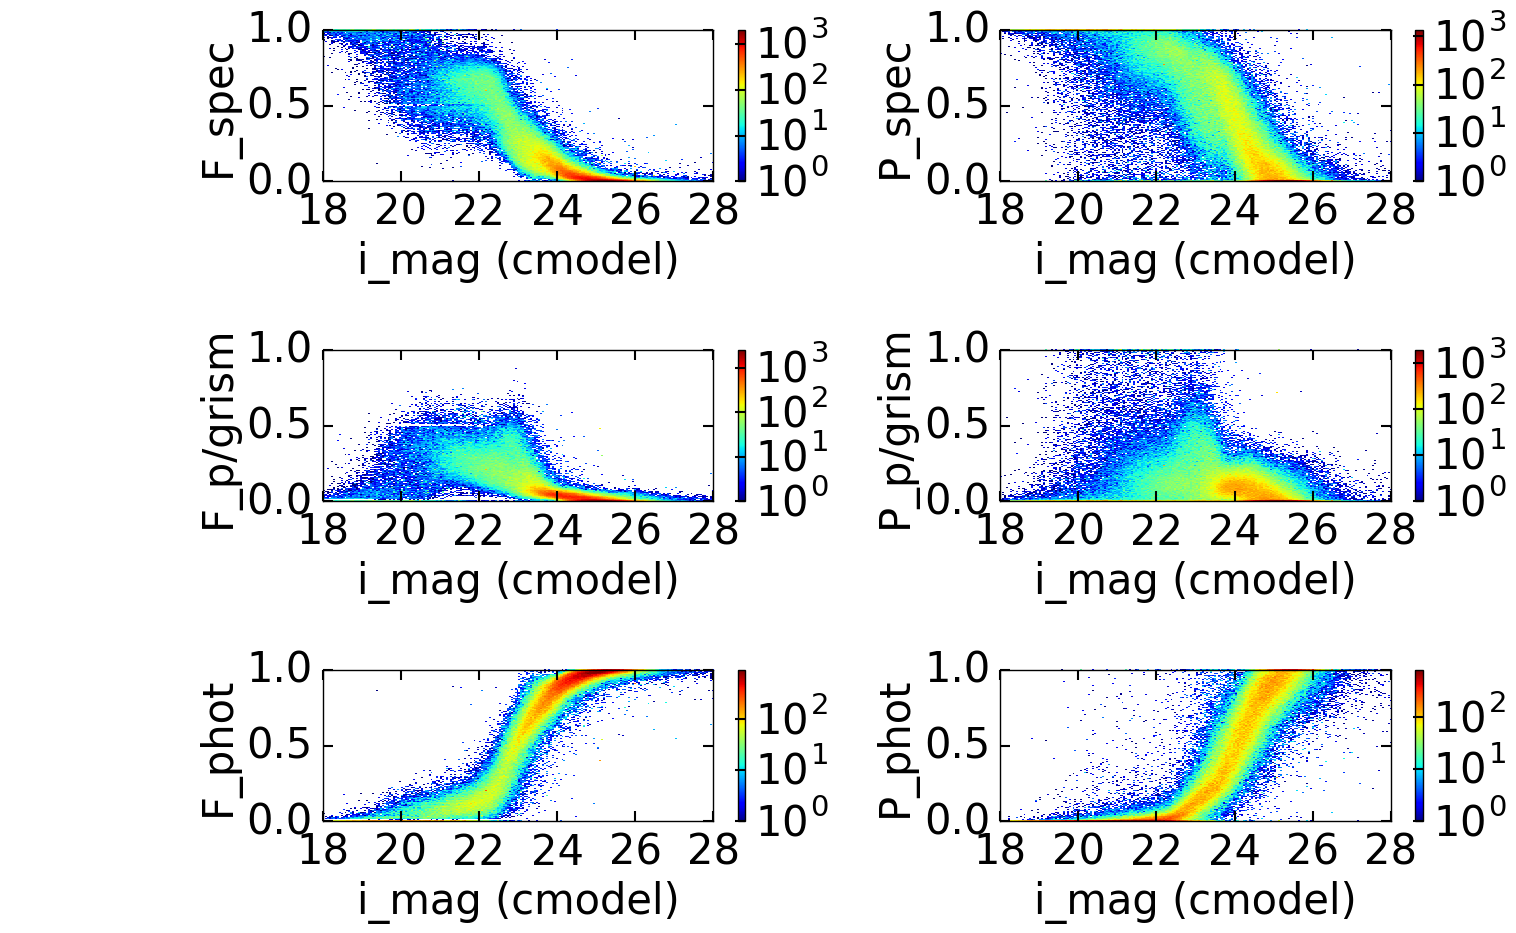

In [73]:
figure(figsize=(14,10))
subplot(3,2,1)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,0]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_spec')
tight_layout()
subplot(3,2,2)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,0],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_spec')
tight_layout()
subplot(3,2,3)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,1]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_p/grism')
tight_layout()
subplot(3,2,4)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,1],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_p/grism')
tight_layout()
subplot(3,2,5)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,2]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_phot')
tight_layout()
subplot(3,2,6)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,2],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_phot')
tight_layout()

As expected, this has boosted the portion of our likelihood arising from spec-z's at these faint magnitudes. Let's now see how this affects our derived $dN/dz$ distribution.

In [74]:
fh=zeros(Nobs)
model_llmin=empty(Nobs) # min(log-likelihood)

for i in xrange(Nobs):
    Nm=model_Nobj[i] # number of models
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm] # model indices and corresponding log-likelihoods
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # weights
    weights[isfinite(weights)==False]=0 # assign failed computations (nan,inf) 0 weight
    weights*=p_fh[midx] # multiply by global prior
    weights/=weights.sum() # normalize
    fh[midx]+=weights # stack

In [75]:
N_samples=100
fh_t=zeros((N_samples,len(fh)))

# Gibbs sampler
fh_t[0]=fh # initialize

for i in xrange(N_samples-1):
    sys.stdout.write(str(i)+' ')
    fh_i=random.dirichlet(fh_t[i]+1) # draw population
    for j in xrange(Nobs):
        Nm=model_Nobj[j] # number of models
        midx,ll,llmin=model_obj[j][:Nm],model_ll[j][:Nm],model_llmin[j]
        weights=exp(-0.5*(ll-llmin))
        weights[isfinite(weights)==False]=0 # assign failed computations (nan,inf) 0 weight
        weights*=fh_i[midx]*p_fh[midx] # (P(pop_global)*P(pop_conditional)*likelihood)
        fh_t[i+1][midx]+=weights/weights.sum()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

([], <a list of 0 Text yticklabel objects>)

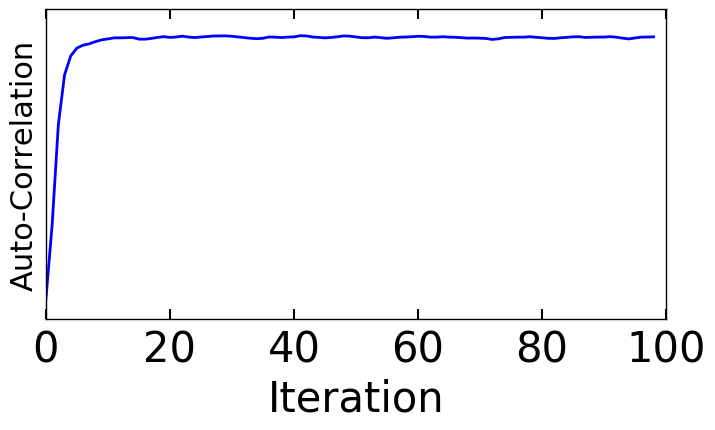

In [76]:
figure(figsize=(8,4))
plot([correlate(fh_t[i+1],fh_t[i]) for i in xrange(N_samples-1)],color='blue',lw=2)
xlabel('Iteration')
ylabel('Auto-Correlation',fontsize=22)
yticks([])

In [77]:
N_burnin=20 # burn-in trials
z_pdf_draws=empty((N_samples-N_burnin,rdict.Nz_out)) # dn/dz draws

for i in xrange(N_burnin,N_samples):
    sys.stdout.write(str(i)+': ')
    midx=choice(Nobs,p=fh_t[i]/fh_t[i].sum(),size=Nobs) # sample from f^h
    temp1,temp2,temp3=lzidx[midx],lzeidx[midx],cv_weights[midx]
    pz=zeros(rdict.lzgrid_highres.shape)
    for j in xrange(Nobs):
        if j%20000==0: sys.stdout.write(str(j/20000)+' ')
        t1,t2,t3=temp1[j],temp2[j],temp3[j]
        w,k=rdict.sig_width[t2],rdict.sig_dict[t2]
        pz[choice(xrange(t1-w,t1+w+1),p=k/k.sum())]+=t3
    pz=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    pz=interp(rdict.zgrid_out,rdict.zgrid,pz)
    pz/=pz.sum()
    z_pdf_draws[i-N_burnin]=pz
z_pdf_draws_mean=z_pdf_draws.mean(axis=0)
z_pdf_draws_mean/=z_pdf_draws_mean.sum()
z_pdf_draws_std=z_pdf_draws.std(axis=0)

20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 21: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 22: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 24: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 25: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 26: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 27: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 28: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 29: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 31: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 32: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 33: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 34: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 35: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 36: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 37: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 38: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 39: 0 1 2 3 4 5 6 7 8 9 10 11 1

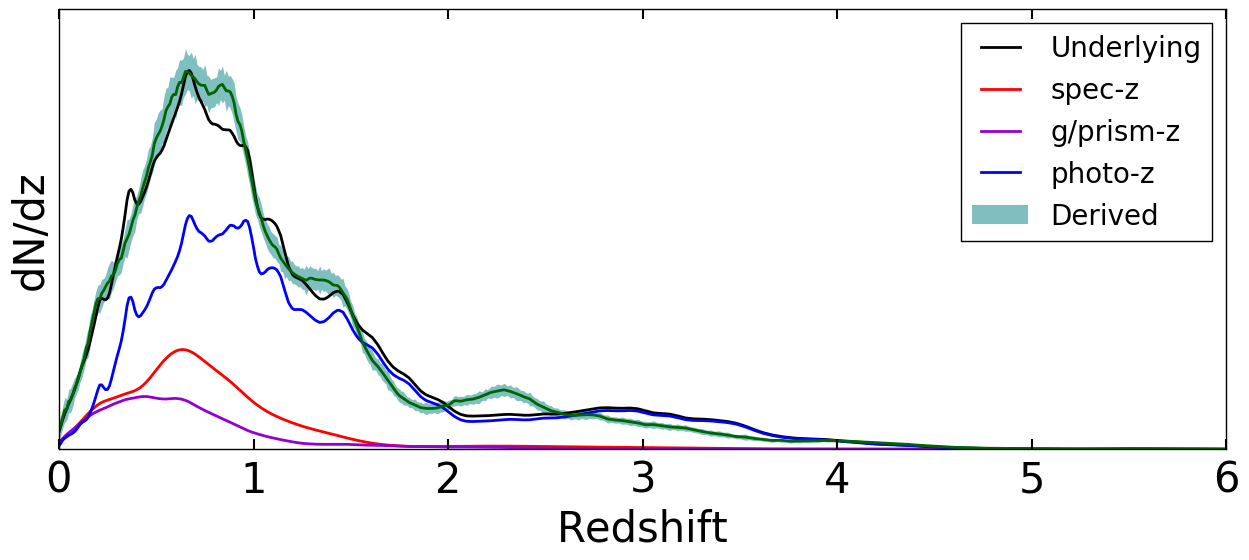

In [78]:
figure(figsize=(14,6))

plot(rdict.zgrid_out,z_pdf,lw=2,color='black',label='Underlying')

ztypes=['spec-z','g/prism-z','photo-z']
zcolors=['red','darkviolet','blue']
for i in xrange(3):
    w=cv_weights*(zt==(i+1))
    z_pdf_t=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,w,rdict.grid,rdict.delta,rdict.Ngrid)
    z_pdf_t=z_pdf_t[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    z_pdf_t=interp(rdict.zgrid_out,rdict.zgrid,z_pdf_t)
    z_pdf_t/=z_pdf_t.sum()
    plot(rdict.zgrid_out,z_pdf_t*w.sum()/cv_weights.sum(),lw=2,color=zcolors[i],label=ztypes[i])

plot(rdict.zgrid_out,z_pdf_draws_mean,lw=2,color='darkgreen')
fill_between(rdict.zgrid_out,z_pdf_draws_mean+z_pdf_draws_std,z_pdf_draws_mean-z_pdf_draws_std,
             color='teal',alpha=0.5,lw=0,label='Derived')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylim([0,None])
yticks([])
ylabel('dN/dz')

As we can see, the change in the distribution is larger than necessarily expected from statistical uncertainties alone, implying that our choice of priors (i.e. how "confident" we are in our training sample) should also be taken into account.